## Importing all necessary libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

## Importing and Analysing the data

In [3]:
df = pd.read_csv("../Power_Load_data/load_data.csv") 
df.head()

,Date_Time,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,Load_Type
0,01-01-2018 00:15,8.753692,2.95,0.0,0.0,73.210000,100.0,900.000000,Light_Load
1,01-01-2018 00:30,4.000000,4.46,0.0,0.0,66.770000,100.0,1800.000000,Light_Load
2,01-01-2018 00:45,3.240000,3.28,0.0,0.0,70.280000,100.0,8070.880991,Light_Load
3,01-01-2018 01:00,3.310000,3.56,0.0,0.0,68.090000,100.0,3600.000000,Light_Load
4,01-01-2018 01:15,3.820000,4.50,0.0,0.0,133.655666,NaN,4500.000000,Light_Load


In [4]:
df.isnull().sum()

Date_Time                                  0
Usage_kWh                               1559
Lagging_Current_Reactive.Power_kVarh     876
Leading_Current_Reactive_Power_kVarh    1156
CO2(tCO2)                                455
Lagging_Current_Power_Factor             350
Leading_Current_Power_Factor            1471
NSM                                      455
Load_Type                                  0
dtype: int64

The given data has null values. So, it is necessary to perform data cleaning process

In [5]:
print(df['Load_Type'].value_counts())

Load_Type
Light_Load      18073
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64


## Data Cleaning

In [6]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'], dayfirst=True, errors='coerce')
df = df.dropna(subset=['Date_Time'])
df.columns = df.columns.str.replace(" ", "_").str.replace(".", "", regex=False)
df.drop_duplicates(inplace=True)

In [7]:
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

## Exploratory Data Analysis

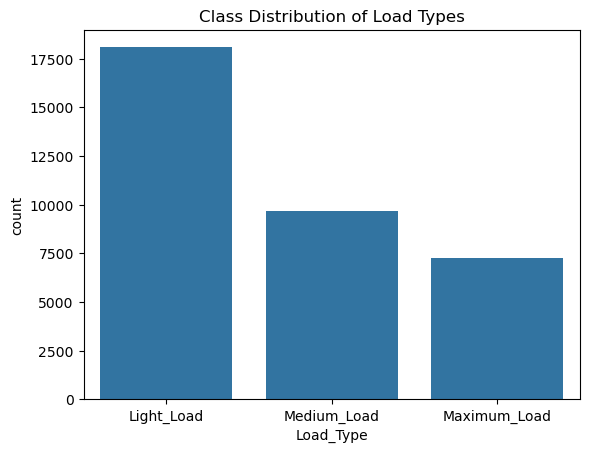

In [8]:
# Load type distribution
sns.countplot(x='Load_Type', data=df)
plt.title("Class Distribution of Load Types")
plt.show()

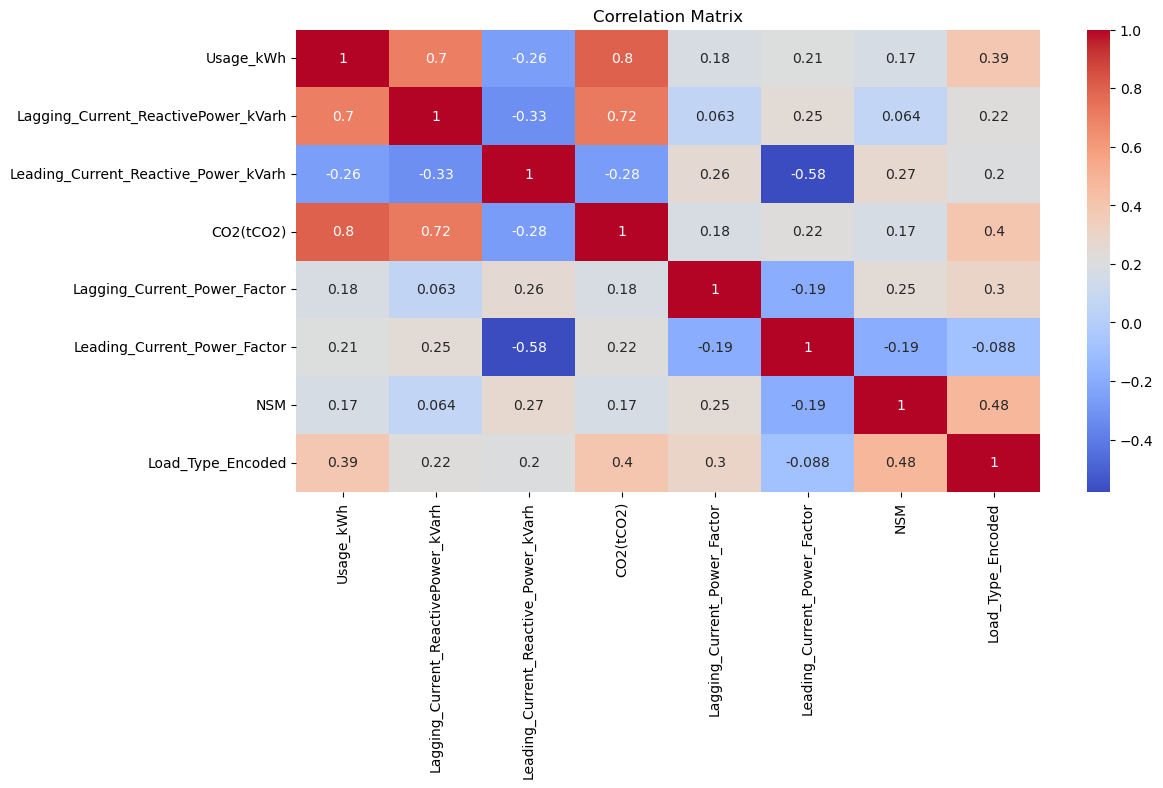

In [9]:
# Correlation heatmap
df_encoded = df.copy()
le = LabelEncoder()
df_encoded['Load_Type_Encoded'] = le.fit_transform(df_encoded['Load_Type'])
plt.figure(figsize=(12, 6))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

## Feature Engineering

In [10]:
df['Hour'] = df['Date_Time'].dt.hour
df['Month'] = df['Date_Time'].dt.month
df['Day'] = df['Date_Time'].dt.day
df.drop('Date_Time', axis=1, inplace=True)

In [11]:
# 🎯 Encode target
le = LabelEncoder()
df['Load_Type'] = le.fit_transform(df['Load_Type'])

## Splitting Data into Train, Validation and Test

In [12]:
X = df.drop('Load_Type', axis=1)
y = df['Load_Type']

In [13]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=42)

## Standardization (Scaling of features)

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Initialization of Models

In [15]:
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
}

## Train the Models

In [16]:
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    val_pred = model.predict(X_val_scaled)
    print(f"\n🔍 {name} - Validation Set Performance")
    print(classification_report(y_val, val_pred, target_names=le.classes_))
    results[name] = model


🔍 Random Forest - Validation Set Performance
              precision    recall  f1-score   support

  Light_Load       0.98      0.98      0.98      3615
Maximum_Load       0.98      0.98      0.98      1454
 Medium_Load       0.95      0.97      0.96      1939

    accuracy                           0.97      7008
   macro avg       0.97      0.97      0.97      7008
weighted avg       0.97      0.97      0.97      7008


🔍 Logistic Regression - Validation Set Performance
              precision    recall  f1-score   support

  Light_Load       0.83      0.86      0.85      3615
Maximum_Load       0.59      0.53      0.56      1454
 Medium_Load       0.55      0.56      0.55      1939

    accuracy                           0.71      7008
   macro avg       0.66      0.65      0.65      7008
weighted avg       0.70      0.71      0.71      7008


🔍 XGBoost - Validation Set Performance
              precision    recall  f1-score   support

  Light_Load       0.99      0.99      0.99  

## Feature Importance

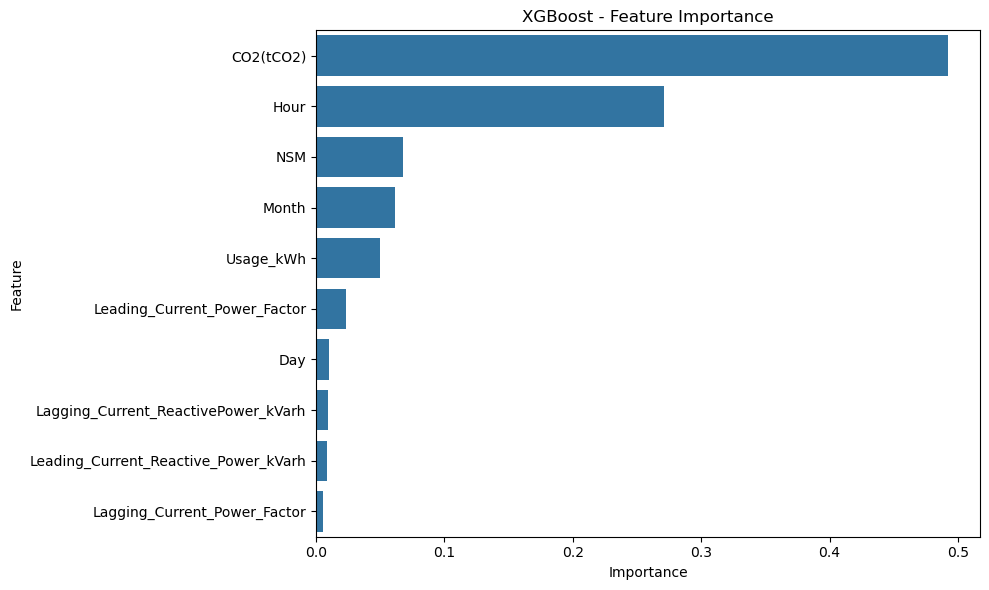

In [17]:
rf_model = results["XGBoost"]
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp)
plt.title("XGBoost - Feature Importance")
plt.tight_layout()
plt.show()

In [18]:
# ✅ Final Model: XGBoost
final_model = results["XGBoost"]
y_test_pred = final_model.predict(X_test_scaled)
print("\n📈 Final Test Set Evaluation (XGBoost):")
print(classification_report(y_test, y_test_pred, target_names=le.classes_))


📈 Final Test Set Evaluation (XGBoost):
              precision    recall  f1-score   support

  Light_Load       0.99      0.99      0.99      3615
Maximum_Load       0.99      0.99      0.99      1455
 Medium_Load       0.98      0.99      0.98      1939

    accuracy                           0.99      7009
   macro avg       0.99      0.99      0.99      7009
weighted avg       0.99      0.99      0.99      7009



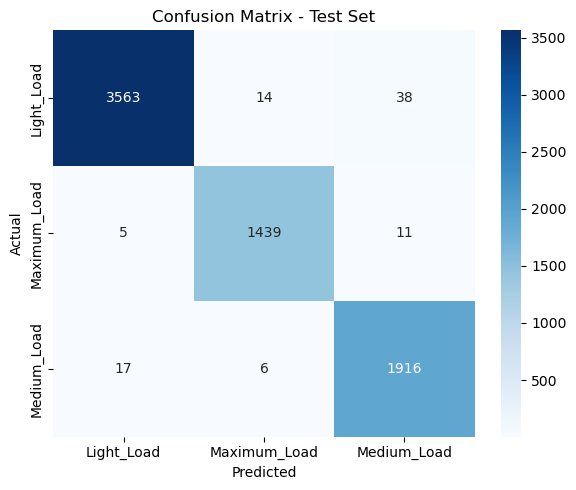

In [19]:
# 📌 Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

## Prediction

In [20]:
# 🔮 Predict on one sample
sample = scaler.transform([X.iloc[0]])
prediction = final_model.predict(sample)
print("\n🔮 Prediction on sample 0:", le.inverse_transform(prediction)[0])


🔮 Prediction on sample 0: Light_Load


## SHAP Analysis


🧠 SHAP Explainability (Top 100 Test Samples)


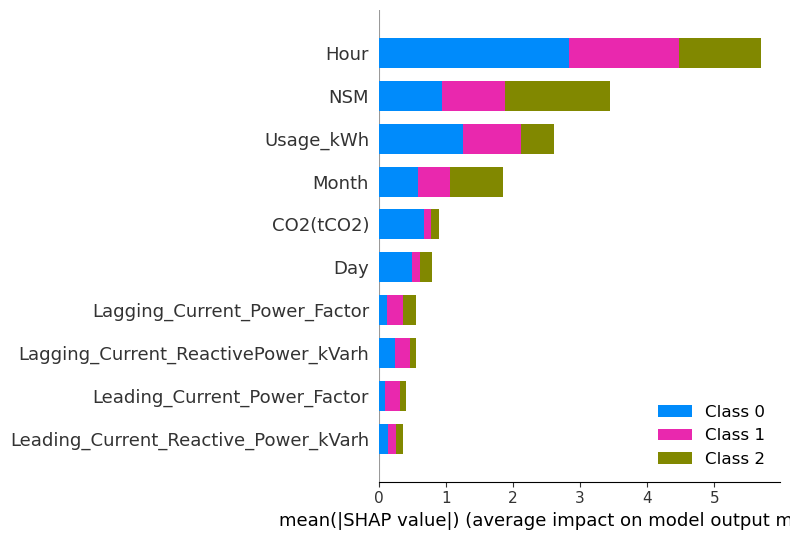

In [21]:
print("\n🧠 SHAP Explainability (Top 100 Test Samples)")
explainer = shap.Explainer(final_model, X_train_scaled)
shap_values = explainer(X_test_scaled[:100])

shap.summary_plot(shap_values, features=X_test.iloc[:100], feature_names=X.columns)